In [1]:
import numpy as np
import pandas as pd
import ta
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
dd = pd.read_excel("Index/data.xlsx")
dd = dd.set_index('Date')
dd =dd.drop(columns='Unnamed: 0')

In [3]:
def Calculate_TA_and_label(dd,c):
    dd['Highest_Close']=dd['High'].rolling(window=26).max()
    dd['Lowest_Close']=dd['Low'].rolling(window =26).min()
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MACD']=ta.trend.macd_diff(dd['Close'], window_slow=26,window_fast=12,fillna= False)
    dd['MA_slow']=((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=30).mean()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['Volume_AVG'] = dd['Volume'].rolling(window=30).mean()
    dd['Low_band'] = dd['Low'].rolling(window=9).mean()
    dd['High_band'] = dd['High'].rolling(window=9).mean()
    dd['Close_only'] = dd['Close'].rolling(window=20).mean()
    dd['Sto_RSI']= (dd['RSI']-dd['RSI'].rolling(window=14).min())/(dd['RSI'].rolling(window=14).max()-dd['RSI']+0.1)
    dd['MA_RSI']= dd['RSI'].rolling(window=14).mean()
    dd['EMA']=ta.trend.ema_indicator(dd['Close'], window = 20, fillna = False)
    #dd['CCI'] = ta.trend.cci(dd['High'],dd['Low'],dd['Close'], window=25,constant=0.015,fillna=False)
    #dd['ROCI']=ta.momentum.ROCIndicator(dd['Close'], window = 12, fillna = False).roc()
    dd['TSI']=ta.momentum.TSIIndicator(dd['Close'], window_slow = 25, window_fast = 13, fillna = False).tsi()
    #dd['MACD_signal']=ta.trend.macd_signal(dd['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)
    #dd['KAMA']=ta.momentum.KAMAIndicator(dd['Close'], window = 10, pow1 = 2, pow2 = 30, fillna = False).kama()
    dd['MFI']=ta.volume.MFIIndicator(dd['High'],dd['Low'],dd['Close'],dd['Volume'], window = 18, fillna = False).money_flow_index()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_hband()
    dd['BB_low_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_lband()
    #dd['WMA']=ta.trend.WMAIndicator(dd['Close'], window = 20, fillna = False).wma()
    # đoạn này là bắt đầu khoai r vì nhìn thì nhiều nhưng thực ra tất cả đều không có quá khó hiểu chỉ là bản chất nó khá là rắc rối :Vvv
    # tớ sẽ giải thích 1 vài chỉ báo trong đống này
    dd['ATR'] =ta.volatility.AverageTrueRange(dd['High'],dd['Low'],dd['Close'],window=14,fillna= False).average_true_range()
    dd['High_Low'] = (dd['High']+dd['Low'])/2
    dd['upper_band'] = dd['High_Low']+2*dd['ATR']
    dd['lower_band'] = dd['High_Low']-2*dd['ATR']
    dd["Target"] = dd["Close"].rolling(2).apply(lambda x: 1 if x.iloc[1] > x.iloc[0]+c else -1 if x.iloc[1] < x.iloc[0]-c else 0).shift(-1)
    dd["Distance"] = dd["Close"].rolling(2).apply(lambda x :round(x.iloc[1] - x.iloc[0],2)).shift(-1)
    final_band_upper=final_band_lower=super_trend=[0 for i in range(len(dd))]
    final_band_upper[0] = dd['upper_band'].iloc[0]
    final_band_lower[0] = dd['lower_band'].iloc[0]
    super_trend[0]= final_band_lower[0]
    for i in range(1,len(dd)) :
        if dd['upper_band'].iloc[i]< final_band_upper[i-1] or dd['Close'].iloc[i-1]>final_band_upper[i-1]:
            final_band_upper[i] = dd['upper_band'].iloc[i]
        else: final_band_upper[i] = final_band_upper[i-1]
        if dd['lower_band'].iloc[i]> final_band_lower[i-1] or dd['Close'].iloc[i-1]<final_band_lower[i-1]:
            final_band_lower[i] = dd['lower_band'].iloc[i]
        else: final_band_lower[i] = final_band_lower[i-1]
        if super_trend[i-1] == final_band_upper[i-1]:
            super_trend[i] = final_band_upper[i] if dd['Close'].iloc[i]<= final_band_upper[i] else final_band_lower[i]
        if super_trend[i-1] == final_band_lower[i-1]:
            super_trend[i] = final_band_lower[i] if dd['Close'].iloc[i]>= final_band_lower[i] else final_band_upper[i]
    dd['Super_trend']=super_trend
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    OBV = ta.volume.OnBalanceVolumeIndicator(close=dd['Close'], volume=dd['Volume']).on_balance_volume()
    OBV_EMA = OBV.ewm(span=8).mean()
    dd['OBV_EMA']=0
    dd.loc[OBV_EMA > OBV_EMA.shift(1), 'OBV_EMA'] = 1
    dd.loc[OBV_EMA < OBV_EMA.shift(1), 'OBV_EMA'] = -1
    DPO = ta.trend.DPOIndicator(dd.Close).dpo()
    dd['DPO']=0
    dd.loc[DPO > 0, 'DPO'] = 1
    dd.loc[DPO < 0, 'DPO'] = -1
    MFI = ta.volume.MFIIndicator(dd.High, dd.Low, dd.Close, dd.Volume).money_flow_index()
    dd['MFI']=0
    dd.loc[MFI > 80, 'MFI'] = 1
    dd.loc[MFI < 20, 'MFI'] = -1
    dd['bs']=dd['Close']-dd['Close_vn30']
    return dd

In [4]:
def Sign_signal(Close,MA,High,Low,BB_high,BB_low,RSI,BB_low_RSI,BB_high_RSI,BB_low_vol,BB_high_vol,Volume,MACD,Low_band,Close_only,EMA,MFI,MA_RSI,super_trend,vnindex,vn30,MA_slow,Volume_AVG,DPO,OBV_EMA,Basic):
    Day_Signal=[[] for i in range(len(Close))]
    temp=0
    rs=[]
    for i in range(len(Close)):
        Day_Signal[i].append(sum(RSI[t]>=RSI[t+1]for t in range(i-20,i)))
        Day_Signal[i].append(sum(Close[t]>=Close[t+1] for t in range(i-4,i)))
        Day_Signal[i].append(MA[i]/Close[i])
        Day_Signal[i].append(MA[i]/MA[i-1])
        Day_Signal[i].append(sum(Close[t]>MA[t] for t in range(i-9,i+1)))
        Day_Signal[i].append((BB_high[i]-High[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append((BB_low[i]-Low[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append(Volume[i]/Volume_AVG[i])
        Day_Signal[i].append(sum(MACD[t] for t in range(i-9,i+1)))
        Day_Signal[i].append(sum(Volume[t]>Volume[t-1] for t in range(i-9,i+1)))
        Day_Signal[i].append(RSI[i]/(BB_high_RSI[i]-BB_low_RSI[i]))
        Day_Signal[i].append(vnindex[i]/vnindex[i-3]-vn30[i]/vn30[i-3])
        Day_Signal[i].append(sum(vnindex[j-1]>vnindex[j-2] and vn30[j-1]>vn30[j-2] for j in range(i-20,i+1)))
        Day_Signal[i].append(vn30[i]-vn30[i-1])
        Day_Signal[i].append(DPO[i])
        Day_Signal[i].append(Basic[i])

    return Day_Signal

In [5]:
def Calculate_feature_remove_outlier(dd,c):
    Signal= Sign_signal(dd.Close,dd.MA,dd.High,dd.Low,dd.BB_high,dd.BB_low,dd.RSI,dd.BB_low_RSI,dd.BB_high_RSI,dd.BB_low_vol,dd.BB_high_vol,dd.Volume,dd.MACD,dd.Low_band,dd.Close_only,dd.EMA,dd.MFI,dd.MA_RSI,dd.Super_trend,dd.Close_vnind,dd.Close_vn30,dd.MA_slow,dd.Volume_AVG,dd.DPO,dd.OBV_EMA,dd.bs)
    dd_Signal = pd.DataFrame(Signal,index=dd.index)
    Date = '2022-06-01'
    Date_start = '2018-01-11'
    Date2 ='2022-06-01'
    Date_end = '2024-01-01'
    Train = dd.loc[Date_start:Date]
    Test = dd.loc[Date2:Date_end]
    Signal_Train= dd_Signal.loc[Date_start:Date]
    Signal_Test= dd_Signal.loc[Date2:Date_end]
    Signal_Train_pd =pd.DataFrame(Signal_Train, index = Train.index)
    Signal_Train_pd['Target'] = Train['Target']
    Signal_Train_pd['Distance'] = Train['Distance']
    Signal_Train_pd['Close']=Train['Close']
    Signal_Train_pd = Signal_Train_pd.drop(Signal_Train_pd[abs(Signal_Train_pd['Distance'])>Signal_Train_pd['Close']*c].index)
    label_train = Signal_Train_pd['Target']
    distance_train = Signal_Train_pd['Distance']
    Signal_Train_pd=Signal_Train_pd.drop(columns=['Target','Distance','Close'])
    return Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train

In [6]:
def command(y_pred_trend,y_true_price):
    command = []
    command_long = []
    command_short = []
    rate_by_time = []
    position = []
    rate_certain_time = []
    rate = 0
    pred=0
    pos=0
    count = 0
    for i in range(len(y_true_price)):
        if  y_pred_trend[i]==1:
                command.append(1)
                command_long.append(1)
                command_short.append(0)
                if pred !=1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred=1
                position.append(pos)
                rate_by_time.append(rate)
        elif  y_pred_trend[i]==-1:
                command.append(-1)
                command_long.append(0)
                command_short.append(1)
                if pred !=-1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred = -1
                position.append(pos)
                rate_by_time.append(rate)
        else:
            command.append(0)
            command_long.append(0)
            command_short.append(0)
            if pred != 0:
                rate = rate+ pred*(y_true_price[i]-pos) 
            pred = 0
            pos =0
            position.append(pos)
            rate_by_time.append(rate)
    return [y_true_price,command,command_long,command_short,rate_by_time,position], count

In [7]:
def portfolio_pnl_future(t,position_long, position_short, Close):
    a=0
    fee=[0]
    for i in range(1,len(t.L)):
        if t.L[i-1]>t.L[i] or t.S[i-1]>t.S[i]:
            a=a+1
            fee.append(a*0.15)
        else:
            fee.append(a*0.15)
    intitial_capital_long = (position_long.iloc[0])*(Close.iloc[0])
    cash_long = (position_long.diff()*Close)
    cash_long[0] = intitial_capital_long
    cash_cs_long = cash_long.cumsum()
    portfolio_value_long = (position_long *Close)

    intitial_capital_short = (position_short.iloc[0])*(Close.iloc[0])
    cash_short = (position_short.diff()* Close)
    cash_short[0] = intitial_capital_short
    cash_cs_short = cash_short.cumsum()
    portfolio_value_short = (position_short* Close)

    backtest = (portfolio_value_long - cash_cs_long).iloc[1:] + (cash_cs_short - portfolio_value_short).iloc[1:]-fee[1:]
    cash_max = (cash_long + cash_short).max()
    pnl =  backtest/cash_max
    
    return backtest, cash_max, pnl

def Sharp(pnl):
    r = pnl.diff(1)
    return np.abs(r.mean())/r.std() * np.sqrt(252)

def maximum_drawdown_future(backtest, cash_max):
    return (backtest.cummax() - backtest).max(), (backtest.cummax() - backtest).max()/cash_max

In [8]:
k = 0
h=2
l=0
dd = Calculate_TA_and_label(dd,k/100)
Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train = Calculate_feature_remove_outlier(dd,h)

X = Signal_Train
y = label_train
X_test_final = Signal_Test
y_test_final = Test["Target"]

y[y==0] =1 
y_test_final[y_test_final==0] =1 

/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3724/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1
/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3724/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1


from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)
X_test_final = sc.transform(X_test_final)

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#Train set will be divided to smaller parts 
tscv = TimeSeriesSplit(n_splits = 50, max_train_size = None, test_size = 20, gap = 0)


In [10]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def CalculateSharp(y_true, preds):   
    
    for i in range(len(preds)):
        if preds[i]==0:
            preds[i]=preds[i-1]
    y_true_score = pd.DataFrame(y_true)
    y_true_score['Close'] = dd.Close        
    t,fee= command(preds,y_true_score.Close)
    t[0]=t[0].tolist()
    t= pd.DataFrame(t).transpose()
    t.columns=['Close','Command','L','S','Total_gain','Position']
    t.index = y_true.index 
    backtest, cash_max,pnl= portfolio_pnl_future(t,t.L,t.S,t.Close)
    backtest.index = pd.to_datetime(backtest.index)
    pnl = portfolio_pnl_future(t,t.L, t.S, t.Close)[0]
    pnl.index = pd.to_datetime(pnl.index)
    pnl = pnl.resample('1D').last().dropna()
    sharp = Sharp(backtest.resample('1D').last().dropna())
    f1 = f1_score(y_true_score.Target,preds)
    return f1 + sharp

custom_scorer = make_scorer(CalculateSharp, greater_is_better=True)

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
param_grid = [{'clf__kernel': ['linear'], 'clf__C': [0.01, 0.1, 1, 10, 100]}]

grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 3,scoring = custom_scorer, cv = tscv) 
grid.fit(X, y)


Fitting 50 folds for each of 5 candidates, totalling 250 fits
[CV 1/50] END ..clf__C=0.01, clf__kernel=linear;, score=2.987 total time=   0.0s
[CV 2/50] END ..clf__C=0.01, clf__kernel=linear;, score=2.842 total time=   0.0s
[CV 3/50] END ..clf__C=0.01, clf__kernel=linear;, score=3.662 total time=   0.0s
[CV 4/50] END ..clf__C=0.01, clf__kernel=linear;, score=2.357 total time=   0.0s
[CV 5/50] END ..clf__C=0.01, clf__kernel=linear;, score=3.860 total time=   0.0s
[CV 6/50] END ..clf__C=0.01, clf__kernel=linear;, score=0.905 total time=   0.0s
[CV 7/50] END ..clf__C=0.01, clf__kernel=linear;, score=0.860 total time=   0.0s
[CV 8/50] END ..clf__C=0.01, clf__kernel=linear;, score=3.052 total time=   0.0s
[CV 9/50] END ..clf__C=0.01, clf__kernel=linear;, score=9.558 total time=   0.0s
[CV 10/50] END .clf__C=0.01, clf__kernel=linear;, score=1.056 total time=   0.0s
[CV 11/50] END .clf__C=0.01, clf__kernel=linear;, score=4.160 total time=   0.0s
[CV 12/50] END .clf__C=0.01, clf__kernel=linear

[CV 4/50] END .....clf__C=1, clf__kernel=linear;, score=3.917 total time=   0.0s
[CV 5/50] END .....clf__C=1, clf__kernel=linear;, score=2.252 total time=   0.0s
[CV 6/50] END .....clf__C=1, clf__kernel=linear;, score=0.801 total time=   0.0s
[CV 7/50] END .....clf__C=1, clf__kernel=linear;, score=1.651 total time=   0.0s
[CV 8/50] END .....clf__C=1, clf__kernel=linear;, score=4.626 total time=   0.0s
[CV 9/50] END .....clf__C=1, clf__kernel=linear;, score=4.390 total time=   0.0s
[CV 10/50] END ....clf__C=1, clf__kernel=linear;, score=4.393 total time=   0.0s
[CV 11/50] END ....clf__C=1, clf__kernel=linear;, score=5.002 total time=   0.0s
[CV 12/50] END ....clf__C=1, clf__kernel=linear;, score=4.372 total time=   0.0s
[CV 13/50] END ....clf__C=1, clf__kernel=linear;, score=2.531 total time=   0.0s
[CV 14/50] END ....clf__C=1, clf__kernel=linear;, score=4.880 total time=   0.0s
[CV 15/50] END ....clf__C=1, clf__kernel=linear;, score=1.649 total time=   0.0s
[CV 16/50] END ....clf__C=1,

[CV 6/50] END ...clf__C=100, clf__kernel=linear;, score=1.542 total time=   0.2s
[CV 7/50] END ...clf__C=100, clf__kernel=linear;, score=3.774 total time=   0.2s
[CV 8/50] END ...clf__C=100, clf__kernel=linear;, score=7.277 total time=   0.2s
[CV 9/50] END ...clf__C=100, clf__kernel=linear;, score=4.390 total time=   0.2s
[CV 10/50] END ..clf__C=100, clf__kernel=linear;, score=4.393 total time=   0.4s
[CV 11/50] END ..clf__C=100, clf__kernel=linear;, score=5.002 total time=   0.2s
[CV 12/50] END ..clf__C=100, clf__kernel=linear;, score=4.957 total time=   0.3s
[CV 13/50] END ..clf__C=100, clf__kernel=linear;, score=2.531 total time=   0.5s
[CV 14/50] END ..clf__C=100, clf__kernel=linear;, score=4.769 total time=   0.5s
[CV 15/50] END ..clf__C=100, clf__kernel=linear;, score=1.649 total time=   0.7s
[CV 16/50] END ..clf__C=100, clf__kernel=linear;, score=4.622 total time=   0.4s
[CV 17/50] END ..clf__C=100, clf__kernel=linear;, score=0.776 total time=   0.4s
[CV 18/50] END ..clf__C=100,

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=50, test_size=20),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid=[{'clf__C': [0.01, 0.1, 1, 10, 100],
                          'clf__kernel': ['linear']}],
             scoring=make_scorer(CalculateSharp), verbose=3)

In [12]:
grid.best_score_, grid.best_params_

(3.698013255670462, {'clf__C': 1, 'clf__kernel': 'linear'})

In [13]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=1, kernel='linear'))])

In [14]:
X_test_final = X_test_final.iloc[:-1]
y_test_final = y_test_final.iloc[:-1]
Test = Test.iloc[:-1]
y_pred = grid.predict(X_test_final)


In [15]:
# Import accuracy score
ac = accuracy_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred, average = "macro")
print('Accuracy : {:.2f}'.format(ac))
print('f1 : {:.2f}'.format(f1))

Accuracy : 0.59
f1 : 0.58


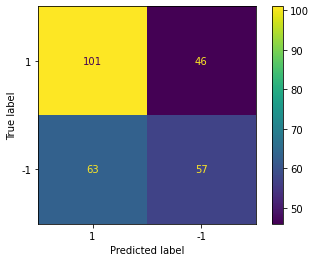

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_final, y_pred, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels= [1, -1])
disp.plot()

plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test_final, y_pred)) 

              precision    recall  f1-score   support

        -1.0       0.55      0.47      0.51       120
         1.0       0.62      0.69      0.65       147

    accuracy                           0.59       267
   macro avg       0.58      0.58      0.58       267
weighted avg       0.59      0.59      0.59       267



In [18]:
t,fee= command(y_pred, Test.Close)

t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
print(t,fee)

      Close  Command    L    S  Total_gain  Position
0    1326.0     -1.0  0.0  1.0       -0.15    1326.0
1    1315.0      1.0  1.0  0.0       10.70    1315.0
2    1318.5     -1.0  0.0  1.0       14.05    1318.5
3    1315.0     -1.0  0.0  1.0       14.05    1318.5
4    1315.0     -1.0  0.0  1.0       14.05    1318.5
..      ...      ...  ...  ...         ...       ...
262  1096.5      1.0  1.0  0.0      598.40    1068.0
263  1100.0      1.0  1.0  0.0      598.40    1068.0
264  1115.5      1.0  1.0  0.0      598.40    1068.0
265  1114.0      1.0  1.0  0.0      598.40    1068.0
266  1119.1      1.0  1.0  0.0      598.40    1068.0

[267 rows x 6 columns] 96


598.4000000000008 96


/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3724/1243101372.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


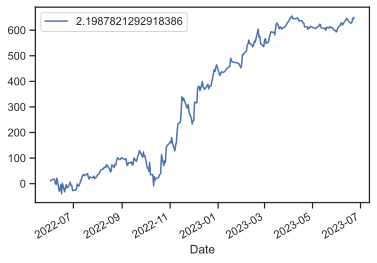

In [19]:
import seaborn as sns
from IPython.display import set_matplotlib_formats

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('svg')

t,fee= command(y_pred,Test.Close)
t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
t.index = Test.index
print(t.Total_gain.iloc[-1],fee) 

backtest, cash_max,pnl= portfolio_pnl_future(t,t.L,t.S,t.Close)
backtest.index = pd.to_datetime(backtest.index)
pnl = portfolio_pnl_future(t,t.L, t.S, t.Close)[0]
pnl.index = pd.to_datetime(pnl.index)

pnl = pnl.resample('1D').last().dropna()
backtest.plot(label = Sharp(backtest.resample('1D').last().dropna()))
plt.legend()
plt.savefig('pnl.png')


In [20]:
print('Sharp', Sharp(backtest.resample('1D').last().dropna()))

Sharp 2.1987821292918386


In [21]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_linear,"{'clf__C': 1, 'clf__kernel': 'linear'}",1,3.698013,2.342702
10_linear,"{'clf__C': 10, 'clf__kernel': 'linear'}",2,3.658609,2.402471
100_linear,"{'clf__C': 100, 'clf__kernel': 'linear'}",3,3.625225,2.293688
0.01_linear,"{'clf__C': 0.01, 'clf__kernel': 'linear'}",4,3.362065,2.459083
0.1_linear,"{'clf__C': 0.1, 'clf__kernel': 'linear'}",5,3.302196,2.045529


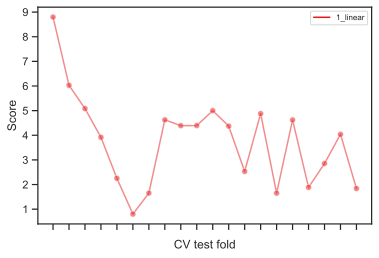

Correlation of models:
 kernel       1_linear  10_linear  100_linear  0.01_linear  0.1_linear
kernel                                                               
1_linear     1.000000   0.954802    0.909213     0.410289    0.740534
10_linear    0.954802   1.000000    0.927571     0.332732    0.726881
100_linear   0.909213   0.927571    1.000000     0.408473    0.720417
0.01_linear  0.410289   0.332732    0.408473     1.000000    0.538418
0.1_linear   0.740534   0.726881    0.720417     0.538418    1.000000


In [22]:

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")
data1=model_scores.transpose().iloc[:20,:1]
# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:20,:1],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
ax.legend(loc="best", fontsize=8)



plt.savefig('increased_size_cv_svm.png')
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")